# Magnetic Fusion Performance

In this demo you'll learn how to predict the performance for fusion devices known as tokamaks. In magnetic confinement fusion, strong magnetic fields are used to to ensure the heat in a 150 million °C fusion plasma is not quickly lost to the surrounding environment.

The rate of this energy loss is measured by the energy confinement time τ. A high confinement time corresponds to a better-performing device, and vice versa. If we have accurate ways of predicting confinement using the design features of a fusion device, then we can better optimise the fusion power-plants of the future.

To get started, let's import the required libraries.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

#twinLab Imports
import twinlab as tl

#set digiLab colors
colors = ["#162448","#009FE3","#7DB928","#FFB500"]

## Set your API Key.

If you don't already have one, please vist https://www.digilab.co.uk/contact. For security, we normally recommend performing this step with a .env file or secrets.

In [2]:
tl.set_api_key("REPLACE_THIS_WITH_YOUR_API_KEY")

Then, we'll load in the experimental data into a pandas dataframe.

The data consists of confinement times measured in several different tokamaks around the world; from JET in the UK, to JT-60 in Japan, to ASDEX in Germany. In addition to the experimentally measured confinement times, the data file also includes parameters that the experiment was run with, like the magnetic field and plasma current.

A good confinement time for magnetic fusion is around 10 seconds, wheras a low, poor confinement time may be around 1 millisecond.

In [3]:
# Import spreadsheet data
sheet = pd.read_excel("HDB5V2.3.xlsx")

Specifically, we'll be focusing on the JET tokamak, with its original carbon wall, using only the high confinement mode (H-mode) shots.

In [4]:
#create a pandas dataframe from imported data
end = -1
df = pd.DataFrame({
    "TAUTH":sheet["TAUTOT]"][0:end], # energy confinement time
    "BT":sheet["BT"][0:end],"IP":sheet["IP"][0:end], #magnetic field
    "PLTH":sheet["PLTH"][0:end], #thermal power
    "RGEO":sheet["RGEO"][0:end], # major radius
    "KAPPA":sheet["KAPPA"][0:end], #elongation
    "NEL":sheet["NEL"][0:end], #electron density
    "MEFF": sheet["MEFF"][0:end], #effective mass number
    "epsilon": sheet["AMIN"][0:end]/sheet["RGEO"][0:end], # inverse aspect ratio
    "TOK": sheet["TOK"][0:end], #tokamak name
    "WALMAT": sheet["WALMAT"][0:end], #material of surrounding walls
    "PHASE": sheet["PHASE"][0:end], #what confinement mode the plasma is in
    })

#ensure all data is numerical and no NANs
df = df.dropna(axis=0)
df['NEL'] = df['NEL'].astype(float)
#pick data corresponding to the JET tokamak
df = df.loc[((df['TOK']=="JET"))]
#select only data with a carbon wall
df = df.loc[["C" in entry for entry in df['WALMAT']]]
#select data only in high-confinement mode, or H-mode
df = df.loc[[((entry=="H") or (entry=="HSELM") or (entry=="HGELM")) for entry in df['PHASE']]]


Now that we've prepared the data, we can now start to interrogate it. For example, we can plot confinement time against the toroidal magnetic field for the chosen JET experiments:

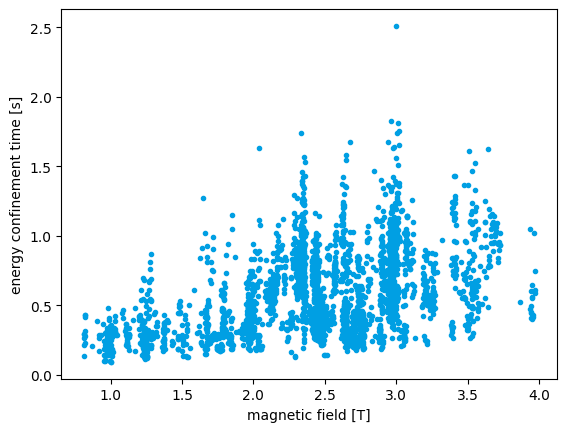

In [5]:
#plot the energy confinement time against toroidal magnetic field
plt.plot(np.abs(df["BT"]),df["TAUTH"],".",alpha=1,color=colors[1])
plt.xlabel("magnetic field [T]")
plt.ylabel("energy confinement time [s]")
plt.show()

We can see there's a rough positive correlation between the two; as magnetic field increases, so does energy confinement time. However, they are not perfectly correlated and the relationship seems very unclear and messy. This is because there are more than 7 other important parameters changing across these experiments, so of course it's difficult to see a clear relationship when only 1 of the features is used for plotting.

## Now we will use twinLab and train a Gaussian Process (GP) emulator on the data.

In [6]:
dflog = df.copy()
#transform data into log space
dflog["IP"] = np.log10(np.abs(df["IP"]))
dflog["BT"] = np.log10(np.abs(df["BT"]))
dflog["NEL"] = np.log10(np.abs(df["NEL"]))
dflog["PLTH"] = np.log10(np.abs(df["PLTH"]))
dflog["RGEO"] = np.log10(np.abs(df["RGEO"]))
dflog["KAPPA"] = np.log10(np.abs(df["KAPPA"]))
dflog["epsilon"] = np.log10(np.abs(df["epsilon"]))
dflog["MEFF"] = np.log10(np.abs(df["MEFF"]))
dflog["TAUTH"] = np.log10(np.abs(df["TAUTH"]))

In [7]:
#upload data to the twinLab cloud
dataset = tl.Dataset("confinement_train_dataset")
gp_train = dflog[["BT","IP","KAPPA","NEL","PLTH","TAUTH"]]
dataset.upload(gp_train)

In [8]:
# Initialise emulator
emulator_id = "confinement_emulator"
emulator = tl.Emulator(id=emulator_id)

# Define the training parameters for your emulator
params = tl.TrainParams(train_test_ratio=0.3,shuffle=True,seed=1)

# Train the mulator using the train method
emulator.train(dataset=dataset,inputs = ["BT","NEL","PLTH","IP","KAPPA"],
               outputs=["TAUTH"], params=params,verbose=True)

Model confinement_emulator has begun training.
Emulator confinement_emulator with process ID train-liberating-magnetic-egg is training.
Training status: Your job is currently being processed.
Training status: Your job is currently being processed.
Training status: Your job is currently being processed.
Training status: Your job is currently being processed.
Training status: Your job is currently being processed.
Training status: Your job has finished and is on its way back to you.
Training of emulator confinement_emulator with process ID train-liberating-magnetic-egg is complete!


Then, we can assess the performance of the trained model by plotting the real confinement times against the confinement times predicted by the gaussian process model. Remember these predictions are for the test data, which the GP model hasn't seen yet.

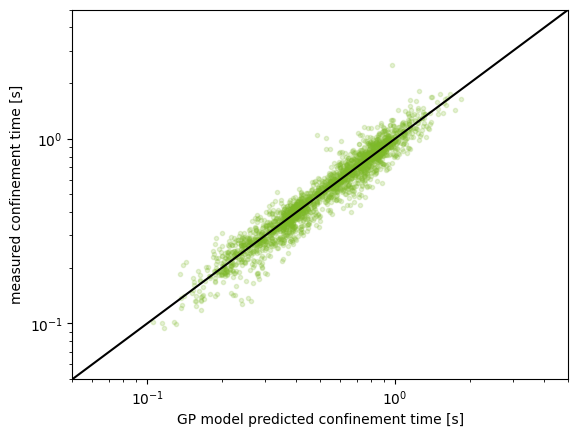

In [9]:
#define the training and test data
train = emulator.view_train_data()
test = emulator.view_test_data()

#predict the confinement time using the emulator on test data
gp_test = test[["BT","IP","KAPPA","NEL","PLTH"]]


df_pred = emulator.predict(test)
result_df = pd.concat([df_pred[0],df_pred[1]],axis=1)
df_mean,df_stdev = result_df.iloc[:,0],result_df.iloc[:,1]
ymean, ystdev = df_mean.values, df_stdev.values

plt.loglog(10**(df_mean),10**(test["TAUTH"]),".",color=colors[2],alpha=0.2)
plt.plot([0.00001,20],[0.00001,20],color="black")
plt.ylim([0.05,5])
plt.xlim([0.05,5])
plt.ylabel("measured confinement time [s]")
plt.xlabel("GP model predicted confinement time [s]")
plt.show()

## Extrapolating to reactors

One vital benefit of using a gaussian process is that it is an inherently probabalistic machine learning method. That means - in addition to making predictions - a GP can output the uncertainty of its predictions.

Let's show this by taking a random point in the JET training data, and fixing all parameters as their value at this point, apart from the toroidal magnetic field. For the field, let's vary it between 1 and 8 tesla.

In [13]:
key = train["BT"].keys()[0] #pick a random piece of training data
extrapolation_points = 150

# produce new data that has constant parameters apart from magnetic field, which varies from 1 to 8 T
field = np.zeros(extrapolation_points)
maxfield = 8
minfield = 1
for i in range(extrapolation_points):
    field[i] = np.log10(minfield+(maxfield-minfield)*i/extrapolation_points)
Upgrade_JET =  pd.DataFrame({"BT":field,"IP":np.zeros(extrapolation_points)+train["IP"][key],
                   "PLTH":np.zeros(extrapolation_points)+train["PLTH"][key],
                   "KAPPA":np.zeros(extrapolation_points)+train["KAPPA"][key],
                   "NEL":np.zeros(extrapolation_points)+train["NEL"][key],
                  })

#run the emulator throughout this region of varying magnetic field
df_pred_extrapolate = emulator.predict(Upgrade_JET)
result_df_pred_upgrade = pd.concat([df_pred_extrapolate[0], df_pred_extrapolate[1]], axis=1)
df_mean_upgrade, df_stdev_upgrade = result_df_pred_upgrade.iloc[:, 0], result_df_pred_upgrade.iloc[:, 1]
y_mean_upgrade, y_stdev_upgrade = df_mean_upgrade.values, df_stdev_upgrade.values

Then we can plot the emulator predictions throughout this range of magnetic fields. Specifically, we can plot the uncertainty bands of the model corresponding to 0.5 and 1 standard deviation.

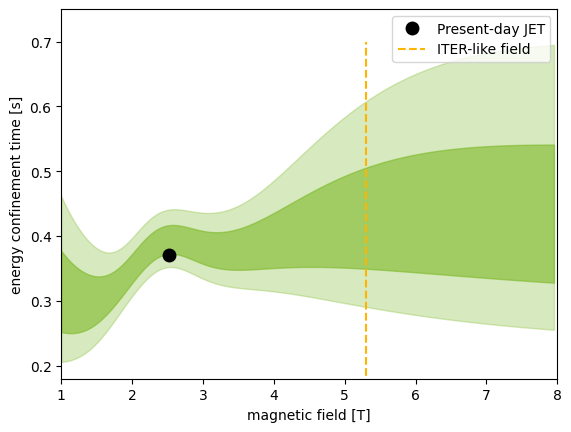

In [14]:
#plot the JET training data in this parameter space
plt.plot(10**(train["BT"][key]),10**(train["TAUTH"][key]),".",color="black",markersize=18,label="Present-day JET")

#plot the gaussian process model prediction and uncertainties
plt.fill_between(
    10**(field),
    10**(df_mean_upgrade+df_stdev_upgrade),
    10**(df_mean_upgrade-df_stdev_upgrade),
    color=colors[2],
    alpha
    =0.3,
)
plt.fill_between(
    10**(field),
    10**(df_mean_upgrade+df_stdev_upgrade/2),
    10**(df_mean_upgrade-df_stdev_upgrade/2),
    color=colors[2],
    alpha=0.6,
)

#show the magnetic field of ITER, a reactor-like device under construction in France
plt.plot([5.3,5.3],[0.1,0.7],linestyle="--",label="ITER-like field",color=colors[3])

plt.xlim([1,8])
plt.ylim([0.18,0.75])
plt.xlabel("magnetic field [T]")
plt.ylabel("energy confinement time [s]")
plt.legend()
plt.savefig("notebook_extrapolate.png",dpi=400)
plt.show()

As you can see from the figure, as we move further and further away from the known parameter space (where our training data is), the gaussian process becomes more and more uncertain. This is important because future, reactor-like tokamaks such as ITER (below) will be much larger, and have stronger magnetic fields than devices like JET. As we move into this unkown regime which is far away from the data our models are trained on, it's absolutely vital to quantify and understand the uncertainty in our models.

This challenge is a real one facing fusion, and models like the those we've built here have been used to influence the design of tokamaks for decades. The importance and impact of what you've done here cannot be overstated!

Of course, the work doesn't end here. If you'd like, try to go back over this tutorial and train models on a different machine, or using differnt inputs or methods. Or, if you'd like to dive deeper into probabalistic machine learning methods, check out our other tutorials on the digiLab website.